## 输出总结果

In [226]:
import argparse
import json
import sys, os
import pandas as pd
import numpy as np

In [598]:
def get_summary(df, filter_error_hw=False):
    cmp_list = ["l1_hit_rate", "l1_hit_rate_g", "l1_hit_rate_ldg", "l1_hit_rate_stg", "l2_hit_rate", "l2_hit_rate_ld", "l2_hit_rate_st",
            "l2_ld_trans","l2_st_trans","l2_tot_trans","dram_ld_trans","dram_st_trans","dram_tot_trans",
            "gmem_tot_reqs", "gmem_ld_sectors", "gmem_st_sectors", "gmem_tot_sectors", "gmem_ld_diverg"]
    
    data = []
    for key in cmp_list:
        y1, y2 = df[f"{key}_hw"], df[f"{key}_sim"]

        if filter_error_hw:
            if "hit_rate" in key:
                valid_hw_res = y1 <= 1.01
                # print(y1.shape)
                shape1 = y1.shape
                y1 = y1[valid_hw_res]
                # print(y1.shape)
                shape2 = y1.shape
                if shape1 != shape2:
                    print(f"{key}: {shape1} -> {shape2}")
                y2 = y2[valid_hw_res]
        
        non_zero_idxs = y1 != 0
        MAPE = np.mean(np.abs(y1[non_zero_idxs] - y2[non_zero_idxs])/y1[non_zero_idxs])

        MAE = np.mean(np.abs(y1-y2))
        RMSE = np.sqrt(np.mean((y1 - y2)**2))
        NRMSE = np.sqrt(np.mean((y1 - y2)**2)) / np.mean(y1)
        corr = np.corrcoef(y1, y2)[0, 1]

        data.append({"MAPE": MAPE, "NRMSE": NRMSE, "Correlation": corr, 'MAE': MAE, 'RMSE':RMSE})
    df_summary = pd.DataFrame(data, index=cmp_list)
    return df_summary
def get_summary_by_bench(df, filter_error_hw=False):
    df_list = []
    keys = ["all"]
    df_list.append(get_summary(df, filter_error_hw=filter_error_hw))
    
    bench_groupby = df.groupby("bench", sort=False, as_index=False)
    for bench, group in bench_groupby:
        print(bench)
        df_list.append(get_summary(group, filter_error_hw=filter_error_hw))
        keys.append(bench)
    
    df_summary = pd.concat(df_list, keys=keys, axis=1)
    return df_summary

In [607]:
def print_compare_table(df_sim1, df_sim2, NRMSE=False):
    cmp_list = {
        'gmem_tot_reqs': 'L1 Reqs',
        'gmem_tot_sectors': 'L1 Sectors',
        'l1_hit_rate': 'L1 Hit Rate',
        'l1_hit_rate_g': 'L1 Hit Rate Global',
        'l1_hit_rate_ldg': 'L1 Hit Rate Global Load',
        # 'l1_hit_rate_stg': 'L1 Hit Rate Global Store',
        'l2_ld_trans': 'L2 Reads',
        'l2_st_trans': 'L2 Writes',
        'l2_tot_trans': 'L2 Total Reqs',
        'l2_hit_rate': 'L2 Hit Rate',
        'l2_hit_rate_ld': 'L2 Read Hit Rate',
        # 'l2_hit_rate_st': 'L2 Write Hit Rate',
        'dram_ld_trans': 'DRAM Reads',
        'dram_st_trans': 'DRAM Writes',
        'dram_tot_trans': 'DRAM Total Reqs',
    }
    def to_percentage(x):
        return "{:.2%}".format(x)
    def round_2digt(x):
        return "{:.2f}".format(x)
    L = []
    eval_metrics = ['MAPE', 'Correlation', 'NRMSE']
    # eval_metrics = ['MAPE', 'Correlation', 'NRMSE', 'MAE', 'RMSE']
    for eval_metric in eval_metrics:
        if 'MAPE' == eval_metric:
            s1 = df_sim1[('all', eval_metric)].apply(to_percentage)
            s2 = df_sim2[('all', eval_metric)].apply(to_percentage)
        # elif 'Correlation'== eval_metric:
        elif True:
            s1 = df_sim1[('all', eval_metric)].apply(round_2digt)
            s2 = df_sim2[('all', eval_metric)].apply(round_2digt)
        else:
            s1 = df_sim1[('all', eval_metric)]
            s2 = df_sim2[('all', eval_metric)]
        L.append(s1)
        L.append(s2)
    merge_df = pd.concat(L, axis=1)
    merge_df.columns = pd.MultiIndex.from_product([eval_metrics, ['Old', 'New']])

    # rename metrics
    select_df = merge_df.loc[cmp_list.keys()].rename(index=cmp_list)
    return merge_df,select_df

### 读取 Excel

In [658]:
# sim_res = 'memory_ppt-gpu_CL128.xlsx'
# sim_res = 'memory_ppt-gpu_CL32.xlsx'
# sim_res2 = 'memory_simulator.xlsx'

# sim_res = 'memory_titanv_TITANV_ppt-gpu_base_CL32_34.xlsx'
# sim_res2 = 'memory_titanv_TITANV_simulator_base_34.xlsx'

# sim_res = 'memory_titanv_A100-40G_ppt-gpu_base_CL32_34.xlsx'
# sim_res2 = 'memory_titanv_A100-40G_simulator_base_34.xlsx'

sim_res = 'memory_titanv_TITANV_ppt-gpu_base_CL32.xlsx'
# sim_res = 'memory_titanv_TITANV_ppt-gpu_base_CL128.xlsx'
sim_res2 = 'memory_titanv_TITANV_simulator_base.xlsx'
# sim_res2 = 'memory_titanv_TITANV_simulator_no_flush_l2.xlsx'
# sim_res2 = 'memory_titanv_TITANV_simulator_fix_l2_write_hit_rate.xlsx'
# sim_res2 = 'memory_titanv_TITANV_sdcm_base.xlsx'
# sim_res2 = 'memory_titanv_TITANV_sdcmL1_base.xlsx'

# # filter
# sim_res = 'memory_titanv_TITANV_simulator_base.xlsx'
# # sim_res2 = 'memory_titanv_TITANV_simulator_nofilterl2.xlsx'
# sim_res2 = 'memory_titanv_TITANV_simulator_no_adaptive.xlsx'

# # sector
# sim_res = 'memory_titanv_TITANV_simulator_base.xlsx'
# # sim_res2 = 'memory_titanv_TITANV_simulator_l2_64CL_32S.xlsx'
# # sim_res2 = 'memory_titanv_TITANV_simulator_l2_64CL_64S.xlsx'
# # sim_res2 = 'memory_titanv_TITANV_simulator_sector_l1_CL32.xlsx'
# # sim_res2 = 'memory_titanv_TITANV_simulator_sector_l1_CL128.xlsx'
# sim_res2 = 'memory_titanv_TITANV_simulator_sector_l2_CL32.xlsx'
# # sim_res2 = 'memory_titanv_TITANV_simulator_sector_l2_CL128.xlsx'

# ## ampere
sim_res = 'memory_titanv_A100-40G_ppt-gpu_base_CL32.xlsx'
sim_res2 = 'memory_titanv_A100-40G_simulator_base.xlsx'
# sim_res2 = 'memory_titanv_A100-40G_sdcmL1_base.xlsx'
# sim_res2 = 'memory_titanv_A100-40G_sdcm_base.xlsx'

# sim_res = 'memory_a100-40g_A100-40G_ppt-gpu_base_CL32.xlsx'
# sim_res2 = 'memory_a100-40g_A100-40G_simulator_base.xlsx'

output_dir = 'paper_draw'

df_sim1 = pd.read_excel(sim_res, sheet_name="apps")
df_sim2 = pd.read_excel(sim_res2, sheet_name="apps")
# df_sim1 = pd.read_excel(sim_res, sheet_name="kernels")
# df_sim2 = pd.read_excel(sim_res2, sheet_name="kernels")
# print(df_sim1.columns)
# print(df_sim2['l2_hit_rate_st_hw'])
# print(df_sim2[df_sim2['l2_hit_rate_st_hw']<1.01].shape)
print(df_sim1.shape, df_sim2.shape)

(49, 39) (49, 39)


### 按照 yaml 重新选择应用

In [518]:
# %env app_yaml=/staff/fyyuan/repo/PPT-GPU-memory/memory_model/memory-apps.yml
# print(os.environ['app_yaml'])

sys.path.insert(0, "/staff/fyyuan/repo/PPT-GPU-memory/")
from scripts.common import parse_app_definition_yaml, get_suite_info, get_app_arg_list

app_yaml = "/staff/fyyuan/repo/PPT-GPU-memory/memory_model/memory-apps.yml"

In [659]:
defined_apps = parse_app_definition_yaml(app_yaml)
suite_info = get_suite_info(app_yaml)

apps = []
for suite in suite_info['suites']:
    apps += defined_apps[suite]
    
app_and_arg_list = get_app_arg_list(apps)
# print(app_and_arg_list[:3])

def filter_app(df):
    df = df[df['app'].isin(app_and_arg_list)]
    # print(df.index)
    return df
df_sim1 = filter_app(df_sim1)
df_sim2 = filter_app(df_sim2)
print(df_sim1.shape, df_sim2.shape)

(37, 39) (37, 39)


### 结果（过滤)

过滤掉命中率大于 1 的应用

In [660]:
df_summary1 = get_summary_by_bench(df_sim1, filter_error_hw=True)
df_summary2 = get_summary_by_bench(df_sim2, filter_error_hw=True)
# print(df_summary2)
_, select_df = print_compare_table(df_summary1, df_summary2, NRMSE=True)
select_df

l1_hit_rate_stg: (37,) -> (13,)
l2_hit_rate: (37,) -> (34,)
l2_hit_rate_ld: (37,) -> (34,)
l2_hit_rate_st: (37,) -> (25,)
rodinia-3.1
l1_hit_rate_stg: (14,) -> (6,)
l2_hit_rate: (14,) -> (11,)
l2_hit_rate_ld: (14,) -> (11,)
l2_hit_rate_st: (14,) -> (9,)
polybench
l1_hit_rate_stg: (9,) -> (2,)
Tango
l1_hit_rate_stg: (3,) -> (1,)
l2_hit_rate_st: (3,) -> (1,)


/tmp/ipykernel_2542080/3280751285.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  NRMSE = np.sqrt(np.mean((y1 - y2)**2)) / np.mean(y1)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


pannotia
l1_hit_rate_stg: (11,) -> (4,)
l2_hit_rate_st: (11,) -> (6,)
l1_hit_rate_stg: (37,) -> (13,)
l2_hit_rate: (37,) -> (34,)
l2_hit_rate_ld: (37,) -> (34,)
l2_hit_rate_st: (37,) -> (25,)
rodinia-3.1
l1_hit_rate_stg: (14,) -> (6,)
l2_hit_rate: (14,) -> (11,)
l2_hit_rate_ld: (14,) -> (11,)
l2_hit_rate_st: (14,) -> (9,)
polybench
l1_hit_rate_stg: (9,) -> (2,)
Tango
l1_hit_rate_stg: (3,) -> (1,)
l2_hit_rate_st: (3,) -> (1,)
pannotia
l1_hit_rate_stg: (11,) -> (4,)
l2_hit_rate_st: (11,) -> (6,)


/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2542080/3280751285.py:27: RuntimeWarning: invalid value encountered in scalar divide
  NRMSE = np.sqrt(np.mean((y1 - y2)**2)) / np.mean(y1)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


MAPE              Correlation       NRMSE  \
                                 Old          New         Old   New   Old   
L1 Reqs                        9.30%        5.19%        1.00  1.00  0.44   
L1 Sectors                    14.10%        8.01%        1.00  1.00  0.56   
L1 Hit Rate                   13.68%       11.46%        0.99  0.99  0.09   
L1 Hit Rate Global            13.66%       11.45%        0.99  0.99  0.09   
L1 Hit Rate Global Load        9.72%        6.77%        1.00  1.00  0.07   
L2 Reads                      25.24%       26.74%        0.97  0.99  1.27   
L2 Writes                     36.02%       39.38%        1.00  1.00  0.91   
L2 Total Reqs                 25.59%       30.17%        1.00  1.00  0.64   
L2 Hit Rate                   30.66%       19.06%        0.64  0.73  0.39   
L2 Read Hit Rate             189.74%       39.24%        0.59  0.88  0.73   
DRAM Reads                    53.56%       22.54%        0.74  0.99  1.68   
DRAM Writes              3285499.65%  5534703.59%        0.50  0.98  3.26   
DRAM Total Reqs               46.46%       45.73%        0.86  0.99  1.48   

                               
                          New  
L1 Reqs                  0.03  
L1 Sectors               0.02  
L1 Hit Rate              0.10  
L1 Hit Rate Global       0.10  
L1 Hit Rate Global Load  0.06  
L2 Reads                 0.31  
L2 Writes                1.22  
L2 Total Reqs            1.04  
L2 Hit Rate              0.36  
L2 Read Hit Rate         0.43  
DRAM Reads               0.27  
DRAM Writes              1.09  
DRAM Total Reqs          0.33

### 结果

In [478]:
df_summary1 = get_summary_by_bench(df_sim1)
df_summary2 = get_summary_by_bench(df_sim2)
# print(df_summary2)
_, select_df = print_compare_table(df_summary1, df_summary2, NRMSE=True)
select_df

rodinia-3.1
polybench
Tango
pannotia


/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


rodinia-3.1
polybench
Tango
pannotia


,MAE,,Correlation,,NRMSE,
,Old Model,New Model,Old Model,New Model,Old Model,New Model
L1 Reqs,11.28%,6.25%,99.99%,100.00%,51.51%,5.71%
L1 Sectors,15.43%,10.07%,99.99%,100.00%,64.72%,7.18%
L1 Hit Rate,27.97%,24.90%,98.80%,98.84%,11.11%,9.69%
L1 Hit Rate Global,26.43%,23.42%,98.80%,98.85%,11.10%,9.68%
L1 Hit Rate Global Load,23.13%,19.72%,99.38%,99.61%,8.74%,6.48%
L2 Reads,30.97%,19.41%,92.99%,89.59%,100.27%,147.13%
L2 Writes,26.35%,20.41%,99.99%,100.00%,53.48%,6.15%
L2 Total Reqs,23.90%,13.85%,99.95%,99.95%,43.36%,19.88%
L2 Hit Rate,39.15%,15.89%,71.68%,92.22%,33.91%,20.55%


### 直接读取 summary 打印结果

In [435]:
df_summary1 = pd.read_excel(sim_res, sheet_name="apps_summary", header=[0, 1], index_col=0)
df_summary2 = pd.read_excel(sim_res2, sheet_name="apps_summary", header=[0, 1], index_col=0)
# df_summary1 = pd.read_excel(sim_res, sheet_name="kernels_summary", header=[0, 1], index_col=0)
# df_summary2 = pd.read_excel(sim_res2, sheet_name="kernels_summary", header=[0, 1], index_col=0)
# print(df_summary2)
_, select_df = print_compare_table(df_summary1, df_summary2, NRMSE=True)

In [436]:
select_df

,MAE,,Correlation,,NRMSE,
,Old Model,New Model,Old Model,New Model,Old Model,New Model
L1 Reqs,8.83%,3.94%,99.99%,100.00%,41.19%,2.31%
L1 Sectors,14.45%,9.21%,99.99%,100.00%,51.15%,1.47%
L1 Hit Rate,14.65%,12.48%,99.29%,99.30%,8.22%,8.34%
L1 Hit Rate Global,14.63%,12.48%,99.29%,99.30%,8.23%,8.34%
L1 Hit Rate Global Load,12.26%,8.84%,99.63%,99.72%,6.16%,5.30%
L2 Reads,27.21%,27.23%,97.22%,99.21%,128.20%,29.80%
L2 Writes,55.59%,56.70%,99.52%,99.37%,94.59%,124.45%
L2 Total Reqs,36.85%,38.43%,99.58%,99.48%,67.89%,106.32%
L2 Hit Rate,42.83%,29.17%,2.89%,35.33%,56.51%,48.12%


### 获取 app 信息

In [619]:
# sys.path.insert(0, "/staff/fyyuan/repo/PPT-GPU-memory/")
%load_ext autoreload
%autoreload 2
from scripts.common import parse_app_definition_yaml, get_suite_info, get_app_arg_list

import inspect
# print(inspect.getsource(get_suite_info))

app_yaml = "/staff/fyyuan/repo/PPT-GPU-memory/memory_model/memory-apps.yml"
# defined_apps = parse_app_definition_yaml(app_yaml)
suite_info = get_suite_info(app_yaml)

sim_res = 'memory_titanv_TITANV_ppt-gpu_base_CL32.xlsx'
df_kernels = pd.read_excel(sim_res, sheet_name="kernels")
df_kernels = filter_app(df_kernels)
df_apps = df_kernels.groupby('app', as_index=False, sort=False).size()
df_apps.rename(columns={'size': 'Kernels'}, inplace=True)
# df_apps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,app,Kernels
0,b+tree-rodinia-3.1/file___data_mil_txt_command...,2
1,backprop-rodinia-3.1/65536,2
2,bfs-rodinia-3.1/__data_graph4096_txt,16
3,cfd-rodinia-3.1/__data_fvcorr_domn_097K,24
4,dwt2d-rodinia-3.1/__data_rgb_bmp__d_1024x1024_...,10
5,gaussian-rodinia-3.1/_s_16,30
6,gaussian-rodinia-3.1/_s_64,126
7,hotspot-rodinia-3.1/1024_2_2___data_temp_1024_...,1
8,lavaMD-rodinia-3.1/_boxes1d_10,1
9,nn-rodinia-3.1/__data_filelist_4__r_5__lat_30_...,1


In [642]:
import subprocess

def get_dir_size(path, get_logic=True):
    if get_logic:
        cmd = f'du --apparent-size {path}'
    else:
        cmd = f"du {path}"
    res = subprocess.run(cmd, shell=True, capture_output=True)
    size = res.stdout.decode().split('\t')[0]
    # print(cmd)
    # print(res.stdout.decode())
    # exit(1)
    return int(size)*1024
    
# print(df_sim1['app'])
# 统计应用 Trace 大小，运行实例数目
bench_info = {
    'abbr': [],
    'trace_size': [],
}
for app_arg in df_apps['app']:
    abbr = suite_info['map'][app_arg][-1]
    print(f"{abbr}: {app_arg}")
    bench_info['abbr'].append(abbr)

    trace_dir = '/staff/fyyuan/hw_trace01/ppt-gpu-titanv/11.0'
    app_memory_trace_dir = os.path.join(trace_dir, app_arg, 'memory_traces')
    # dir_size = 1
    dir_size = get_dir_size(app_memory_trace_dir)
    # print(dir_size)
    bench_info['trace_size'].append(dir_size)
df_bench_info = pd.concat([df_apps, pd.DataFrame(bench_info)], axis=1)
df_bench_info

BTREE: b+tree-rodinia-3.1/file___data_mil_txt_command___data_command_txt
BP: backprop-rodinia-3.1/65536
BFS: bfs-rodinia-3.1/__data_graph4096_txt
CFD: cfd-rodinia-3.1/__data_fvcorr_domn_097K
DWT2D: dwt2d-rodinia-3.1/__data_rgb_bmp__d_1024x1024__f__5__l_3
GS: gaussian-rodinia-3.1/_s_16
GS: gaussian-rodinia-3.1/_s_64
HS: hotspot-rodinia-3.1/1024_2_2___data_temp_1024___data_power_1024_output_out
LMD: lavaMD-rodinia-3.1/_boxes1d_10
NN: nn-rodinia-3.1/__data_filelist_4__r_5__lat_30__lng_90
NW: nw-rodinia-3.1/2048_10
PF: pathfinder-rodinia-3.1/100000_100_20___result_txt
SRAD: srad_v1-rodinia-3.1/100_0_5_502_458
SC: streamcluster-rodinia-3.1/3_6_16_65536_65536_1000_none_output_txt_1_output_txt
2MM: polybench-2mm/NO_ARGS
3MM: polybench-3mm/NO_ARGS
BICG: polybench-bicg/NO_ARGS
GEMM: polybench-gemm/NO_ARGS
GEMVER: polybench-gemver/NO_ARGS
GESUMMV: polybench-gesummv/NO_ARGS
SYRK: polybench-syrk/NO_ARGS
2DCONV: polybench-convolution2D/NO_ARGS
JACOBI2D: polybench-jacobi2D/NO_ARGS
AN: AN/1
GRU: GRU/

,app,Kernels,abbr,trace_size
0,b+tree-rodinia-3.1/file___data_mil_txt_command...,2,BTREE,753604608
1,backprop-rodinia-3.1/65536,2,BP,168092672
2,bfs-rodinia-3.1/__data_graph4096_txt,16,BFS,3971072
3,cfd-rodinia-3.1/__data_fvcorr_domn_097K,24,CFD,764519424
4,dwt2d-rodinia-3.1/__data_rgb_bmp__d_1024x1024_...,10,DWT2D,181318656
5,gaussian-rodinia-3.1/_s_16,30,GS,86016
6,gaussian-rodinia-3.1/_s_64,126,GS,4879360
7,hotspot-rodinia-3.1/1024_2_2___data_temp_1024_...,1,HS,64565248
8,lavaMD-rodinia-3.1/_boxes1d_10,1,LMD,498594816
9,nn-rodinia-3.1/__data_filelist_4__r_5__lat_30_...,1,NN,1712128


In [661]:
g = df_bench_info.groupby('abbr', as_index=False, sort=False)

df_bench_info2 = g.sum()
df_bench_info2

def bytes_to_human(x):
    G, M, K = 2**30, 2**20, 2**10
    if x >= G:
        return f'{x/G:.0f}GB'
    elif x >= M:
        return f'{x/M:.0f}MB'
    else:
        return f'{x/K:.0f}KB'
        
print(f'total: {df_bench_info2["trace_size"].sum()//2**30:.2f}GB')
print(f'total Kernels: {df_bench_info2["Kernels"].sum()}')
df_bench_info2['Trace size'] = df_bench_info2['trace_size'].apply(bytes_to_human)
df_bench_info2.drop(columns=['app'], inplace=True)
df_bench_info3 = df_bench_info2
df_bench_info3['Instance'] = g.size()['size']
df_bench_info3.reindex(columns=['abbr','Instance', 'Kernels', 'Trace size'])

total: 196.00GB
total Kernels: 1736


,abbr,Instance,Kernels,Trace size
0,BTREE,1,2,719MB
1,BP,1,2,160MB
2,BFS,1,16,4MB
3,CFD,1,24,729MB
4,DWT2D,1,10,173MB
5,GS,2,156,5MB
6,HS,1,1,62MB
7,LMD,1,1,475MB
8,NN,1,1,2MB
9,NW,1,255,120MB


### 删除部分应用（obseleted）

In [509]:
# del app
def del_app(df):
    indexes_to_drop = df[df['app'].isin(
        ['bfs-rodinia-3.1/__data_graph65536_txt', 'bfs-rodinia-3.1/__data_graph1MW_6_txt', 'dwt2d-rodinia-3.1/__data_192_bmp__d_192x192__f__5__l_3',
         'gaussian-rodinia-3.1/_f___data_matrix4_txt', 'gaussian-rodinia-3.1/_s_16', 'gaussian-rodinia-3.1/_s_64',
         'lavaMD-rodinia-3.1/_boxes1d_10', 'polybench-atax/NO_ARGS', 'polybench-mvt/NO_ARGS', 
        ]
    )].index
    df.drop(indexes_to_drop, inplace=True)

del_app(df_sim1)
del_app(df_sim2)

## 按 metric 对比

In [512]:
def get_MAPE(df):
    MAPE = (df[f'{metric}_sim'] - df[f'{metric}_hw']) / df[f'{metric}_hw']
    MAPE.name = metric
    MAPE.index = df['app']
    return MAPE
def get_corr(df):
    y1, y2 = df[f'{metric}_sim'], df[f'{metric}_hw']
    corr = np.corrcoef(y1, y2)[0, 1]
    return corr

In [513]:
sim_res = 'memory_titanv_TITANV_ppt-gpu_base_CL32.xlsx'
# sim_res = 'memory_titanv_TITANV_ppt-gpu_base_CL128.xlsx'
sim_res2 = 'memory_titanv_TITANV_simulator_base.xlsx'
metric = 'l2_ld_trans'

df_sim1 = pd.read_excel(sim_res, sheet_name="apps")
df_sim2 = pd.read_excel(sim_res2, sheet_name="apps")
print(df_sim1.shape, df_sim2.shape)
print(f'corr: {get_corr(df_sim1)}, {get_corr(df_sim2)}')

(49, 39) (49, 39)
ppt-gpu: 0.9312200647049099, my: 0.8965355438425157


In [514]:
MAPE1=get_MAPE(df_sim1)
MAPE2=get_MAPE(df_sim2)
df = pd.concat([MAPE1, MAPE2], axis=1)
print(df.mean())
print(df.abs().mean())
df

l2_ld_trans    0.183974
l2_ld_trans   -0.000940
dtype: float64
l2_ld_trans    0.307949
l2_ld_trans    0.193077
dtype: float64


,l2_ld_trans,l2_ld_trans
app,,
b+tree-rodinia-3.1/file___data_mil_txt_command___data_command_txt,0.410911,0.234647
backprop-rodinia-3.1/65536,0.478186,0.017342
bfs-rodinia-3.1/__data_graph4096_txt,0.249143,-0.077188
bfs-rodinia-3.1/__data_graph65536_txt,0.234460,0.285207
bfs-rodinia-3.1/__data_graph1MW_6_txt,0.256138,0.448536
cfd-rodinia-3.1/__data_fvcorr_domn_097K,0.079711,0.088543
dwt2d-rodinia-3.1/__data_192_bmp__d_192x192__f__5__l_3,-0.032601,-0.032401
dwt2d-rodinia-3.1/__data_rgb_bmp__d_1024x1024__f__5__l_3,0.027022,0.001447
gaussian-rodinia-3.1/_f___data_matrix4_txt,-0.849558,-0.849558


## 画图

In [544]:
from scripts.common import get_suite_info

In [284]:
def get_metric_df(df_sim1, df_sim2, metric):
    df1 = df_sim1[['app', f"{metric}_hw", f"{metric}_sim"]]
    df2 = df_sim2[f"{metric}_sim"]
    df_new = pd.concat([df1, df2], axis=1)
    
    # rename columns
    df_new.columns = ['APP', 'HW', 'PPT-GPU-Mem', 'Ours']
    
    app_rename_map = {}
    for app in df_new['APP']:
        abbr = suite_info['map'][app][-1]
        app_rename_map[app] = abbr
    df_new['APP'] = df_new['APP'].map(app_rename_map)
    df_new = df_new.set_index('APP')
    return df_new

def draw_bar(df_sim1, df_sim2, draw_list):
    for metric in draw_list:
        print(f"Drawing {metric}...")
        df_metric = get_metric_df(df_sim1, df_sim2, metric)

        # df_metric.plot.bar()
        # save to excel
        with pd.ExcelWriter(os.path.join(output_dir, f"{metric}.xlsx"), engine='xlsxwriter') as writer:
            df_new.to_excel(writer, sheet_name=metric, index=False)

In [545]:
sim_res = 'memory_titanv_TITANV_ppt-gpu_base_CL32.xlsx'
sim_res2 = 'memory_titanv_TITANV_simulator_base.xlsx'
# sim_res = 'memory_titanv_A100-40G_ppt-gpu_base_CL32.xlsx'
# sim_res2 = 'memory_titanv_A100-40G_simulator_base.xlsx'

df_sim1 = pd.read_excel(sim_res, sheet_name="apps")
df_sim2 = pd.read_excel(sim_res2, sheet_name="apps")

### 绘制结果

In [644]:
# df1 = get_metric_df(df_sim1, df_sim2, 'dram_ld_trans')
df1 = get_metric_df(df_sim1, df_sim2, 'l2_hit_rate')
# df2 = get_metric_df(df_sim1, df_sim2, 'dram_st_trans')
# df3 = get_metric_df(df_sim1, df_sim2, 'dram_tot_trans')

<Axes: xlabel='APP'>

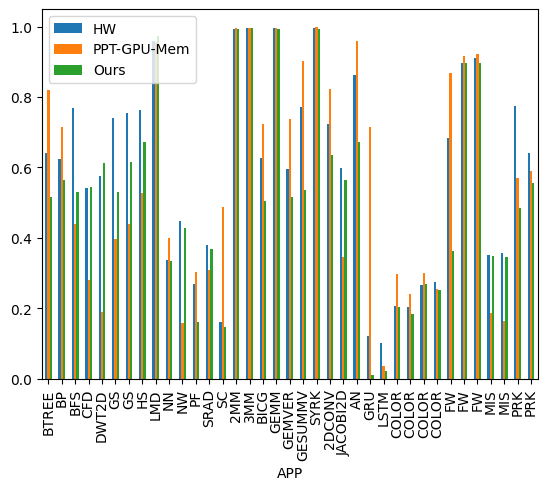

In [646]:
df1.plot.bar()

In [ ]:
# pd.DataFrame({'ld': df1, 'st': df2, 'tot': df3})

In [293]:
def get_MAPE(df):
    df2 = (df['PPT-GPU-Mem'] - df['HW'])/df['HW']
    df3 = (df['Ours'] - df['HW'])/df['HW']
    df4 = pd.concat([df2, df3], axis=1)
    return df4

In [312]:
MAPE = get_MAPE(df3)
print(MAPE.mean())
print(MAPE.abs().mean())
MAPE

0   -0.229418
1    0.454299
dtype: float64
0    0.478751
1    0.578776
dtype: float64


,0,1
APP,,
BTREE,-0.335236,0.611937
BP,-0.242895,1.062116
BFS,-0.519183,0.077606
BFS,-0.361956,0.806368
BFS,0.115770,0.935212
CFD,0.177652,0.349773
DWT2D,0.801260,0.920224
GS,-0.985366,-0.965854
GS,-0.910819,-0.818922


<Axes: xlabel='APP'>

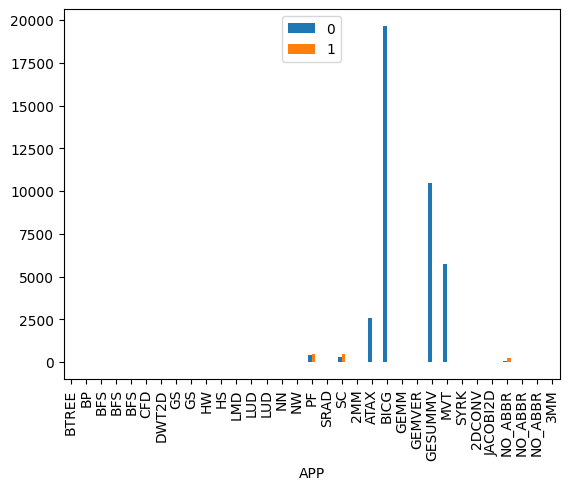

In [159]:
df4.plot.bar()

<Axes: xlabel='APP'>

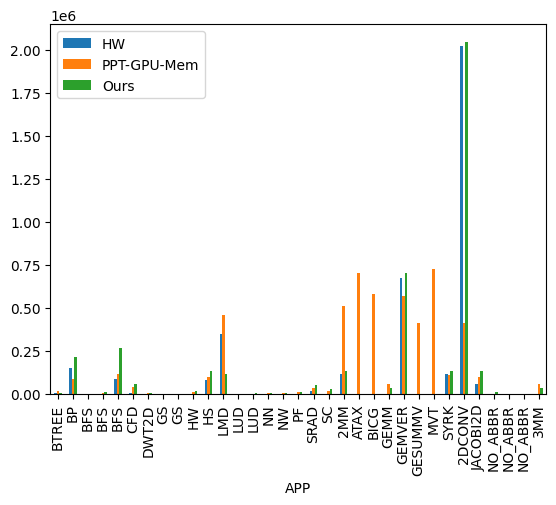

In [160]:
df.plot.bar()